In [54]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# expand the number of rows to display
pd.set_option('display.max_rows', None)

# set graph theme
sns.set_theme()

In [3]:
all = pd.read_csv('/Users/cyc/Documents/01/coding/exercise_database/data_all.csv')

In [44]:
store = pd.read_csv('/Users/cyc/Documents/01/coding/store_sales_prediction/data/stores.csv')
train = pd.read_csv('/Users/cyc/Documents/01/coding/store_sales_prediction/data/train.csv')
test = pd.read_csv('/Users/cyc/Documents/01/coding/store_sales_prediction/data/test.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Store data check

In [56]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
 10  Unnamed: 10                0 non-null      float64
 11  Unnamed: 11                1 non-null      object 
dtypes: float64(6), int64(2), object(4)
memory usage: 104.7+ KB


### Exploratory analysis

#### Distribution

##### store type / assortment

Text(0, 0.5, 'Count')

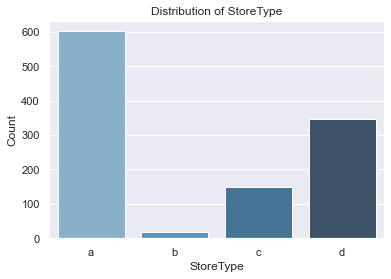

In [24]:
order = ['a', 'b', 'c', 'd']

sns.countplot(x='StoreType', data=store, order=order, palette='Blues_d')
plt.title('Distribution of StoreType')
plt.xlabel('StoreType')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

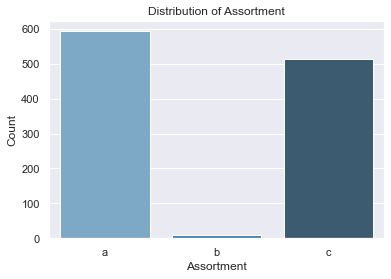

In [26]:
order = ['a', 'b', 'c']

sns.countplot(x='Assortment', data=store, order=order, palette='Blues_d')
plt.title('Distribution of Assortment')
plt.xlabel('Assortment')
plt.ylabel('Count')

In [27]:
store.groupby(['StoreType', 'Assortment'])['Store'].count().reset_index()

,StoreType,Assortment,Store
0,a,a,381
1,a,c,221
2,b,a,7
3,b,b,9
4,b,c,1
5,c,a,77
6,c,c,71
7,d,a,128
8,d,c,220


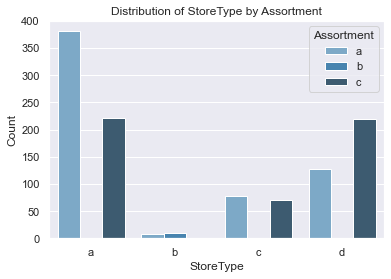

In [31]:
order = ['a', 'b', 'c', 'd']
hue_order = ['a', 'b', 'c']

sns.countplot(x='StoreType', hue='Assortment', data=store, palette='Blues_d', order=order, hue_order=hue_order)
plt.title('Distribution of StoreType by Assortment')
plt.xlabel('StoreType')
plt.ylabel('Count')
plt.legend(title='Assortment')
plt.show()

##### Competition

Text(3.799999999999997, 0.5, 'Count')

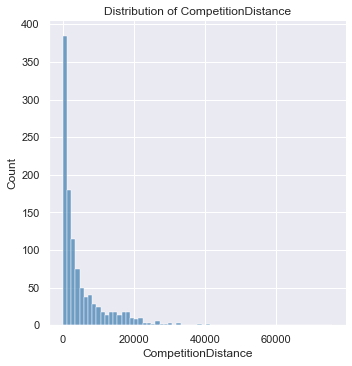

In [34]:
sns.displot(store['CompetitionDistance'], kde=False, color='steelblue')
plt.title('Distribution of CompetitionDistance')
plt.xlabel('CompetitionDistance')
plt.ylabel('Count')

Text(3.799999999999997, 0.5, 'Count')

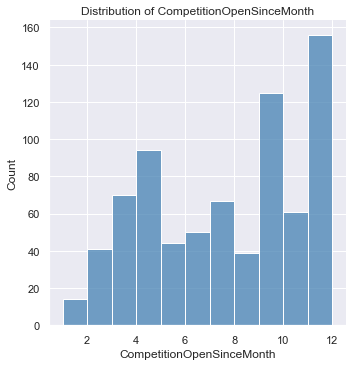

In [35]:
sns.displot(store['CompetitionOpenSinceMonth'], kde=False, color='steelblue')
plt.title('Distribution of CompetitionOpenSinceMonth')
plt.xlabel('CompetitionOpenSinceMonth')
plt.ylabel('Count')

Text(3.799999999999997, 0.5, 'Count')

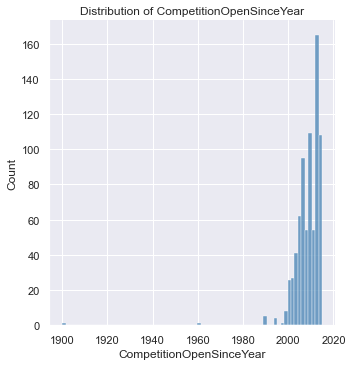

In [36]:
sns.displot(store['CompetitionOpenSinceYear'], kde=False, color='steelblue')
plt.title('Distribution of CompetitionOpenSinceYear')
plt.xlabel('CompetitionOpenSinceYear')
plt.ylabel('Count')

In [15]:
store['CompetitionOpenSinceYear'].describe()

count     761.000000
mean     2008.668857
std         6.195983
min      1900.000000
25%      2006.000000
50%      2010.000000
75%      2013.000000
max      2015.000000
Name: CompetitionOpenSinceYear, dtype: float64

In [14]:
store[store['CompetitionOpenSinceYear']<1970]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Unnamed: 10,Unnamed: 11
145,146,d,c,8050.0,10.0,1961.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",NaN,NaN
814,815,a,a,590.0,1.0,1900.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",NaN,NaN


##### Promo2

Text(0, 0.5, 'Count')

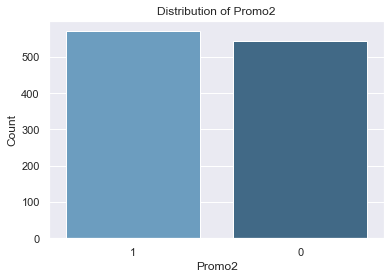

In [33]:
order = [1, 0]

sns.countplot(x='Promo2', data=store, order=order, palette='Blues_d')
plt.title('Distribution of Promo2')
plt.xlabel('Promo2')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

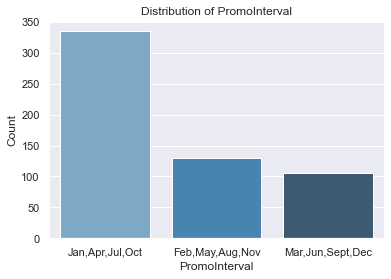

In [40]:
sns.countplot(x='PromoInterval', data=store, palette='Blues_d')
plt.title('Distribution of PromoInterval')
plt.xlabel('PromoInterval')
plt.ylabel('Count')

Text(3.924999999999997, 0.5, 'Count')

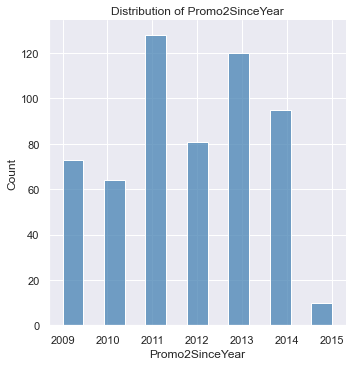

In [37]:
sns.displot(store['Promo2SinceYear'], kde=False, color='steelblue')
plt.title('Distribution of Promo2SinceYear')
plt.xlabel('Promo2SinceYear')
plt.ylabel('Count')

Text(3.799999999999997, 0.5, 'Count')

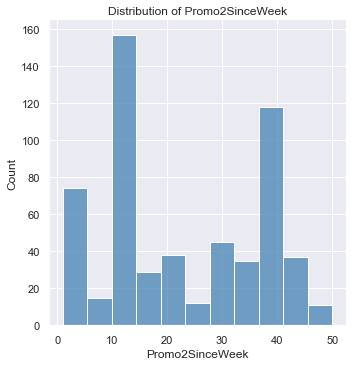

In [38]:
sns.displot(store['Promo2SinceWeek'], kde=False, color='steelblue')
plt.title('Distribution of Promo2SinceWeek')
plt.xlabel('Promo2SinceWeek')
plt.ylabel('Count')

### missing data

#### CompetitionDistance
- extreme right-skewed: using median to fill missing

In [6]:
store[store['CompetitionDistance'].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Text(5.960000000000001, 0.5, 'Count')

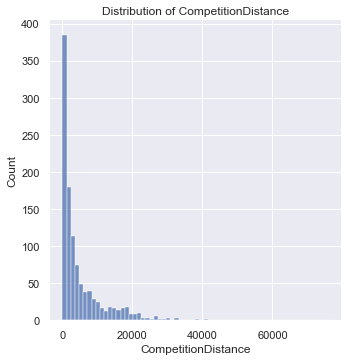

In [64]:
sns.displot(store['CompetitionDistance'], kde=False)
plt.title('Distribution of CompetitionDistance')
plt.xlabel('CompetitionDistance')
plt.ylabel('Count')

#### Competition year & month

In [5]:
end_date = datetime.strptime('01-10-2015', "%d-%m-%Y").date()
store["Competition_total_month"] = (end_date.year- store["CompetitionOpenSinceYear"]) * 12 + (end_date.month - store["CompetitionOpenSinceMonth"])

Text(3.799999999999997, 0.5, 'Count')

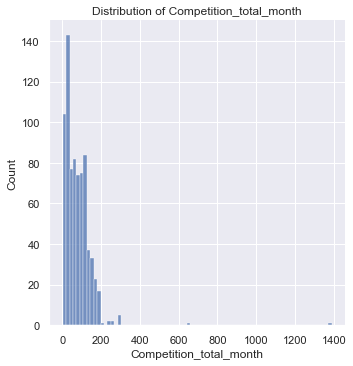

In [8]:
sns.displot(store['Competition_total_month'], kde=False)
plt.title('Distribution of Competition_total_month')
plt.xlabel('Competition_total_month')
plt.ylabel('Count')

In [14]:
store[store['Competition_total_month']>500]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Unnamed: 10,Unnamed: 11,Competition_total_month
145,146,d,c,8050.0,10.0,1961.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",NaN,NaN,648.0
814,815,a,a,590.0,1.0,1900.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",NaN,NaN,1389.0


Text(3.924999999999997, 0.5, 'Count')

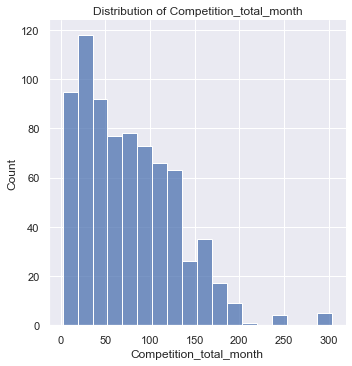

In [12]:
sns.displot(store[store['Competition_total_month']<500]['Competition_total_month'], kde=False)
plt.title('Distribution of Competition_total_month')
plt.xlabel('Competition_total_month')
plt.ylabel('Count')

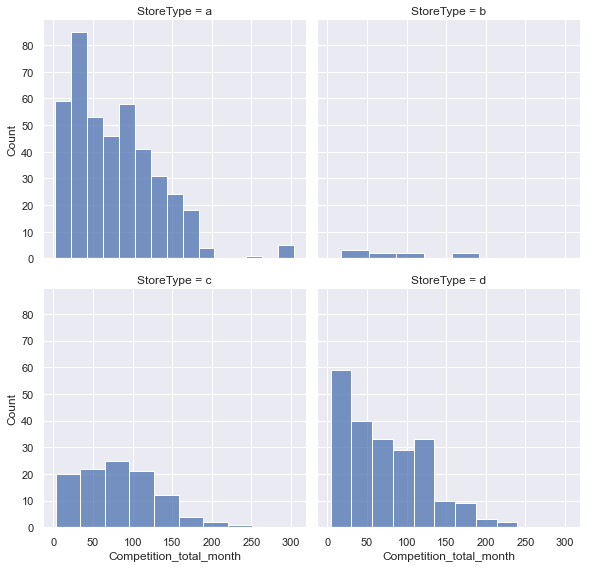

In [15]:
g = sns.FacetGrid(store[store['Competition_total_month']<500], col='StoreType', col_wrap=2, height=4, col_order=['a', 'b', 'c', 'd'])
g.map(sns.histplot, 'Competition_total_month', kde=False)
g.set_axis_labels('Competition_total_month', 'Count')
g.add_legend()

In [16]:
print(store['Competition_total_month'].mean())
print(store['Competition_total_month'].median())

78.74901445466492
68.0


In [17]:
print(store[store['Competition_total_month']<500]['Competition_total_month'].mean())
print(store[store['Competition_total_month']<500]['Competition_total_month'].median())

76.27272727272727
68.0


##### StoreType

In [28]:
store.groupby('StoreType')['CompetitionDistance'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,601.0,5123.061564,8420.917544,20.0,460.0,1790.0,5020.0,75860.0
b,17.0,1060.588235,831.808802,90.0,590.0,900.0,1270.0,3640.0
c,148.0,3522.567568,5944.811048,40.0,490.0,1660.0,3985.0,45740.0
d,346.0,6913.063584,6769.367096,50.0,1880.0,5040.0,9702.5,48330.0


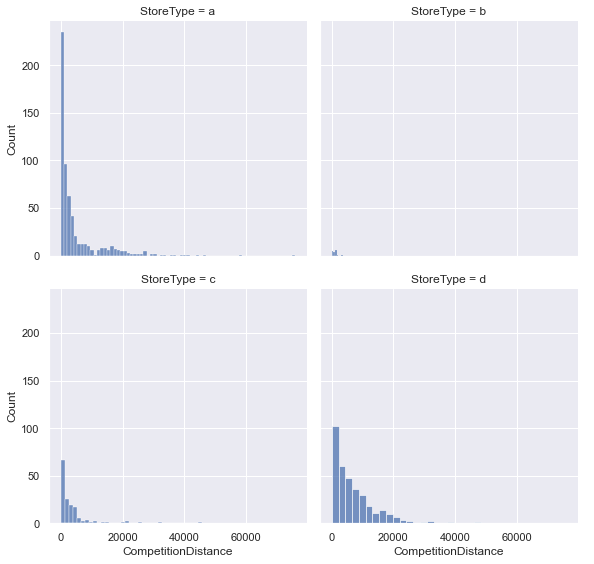

In [66]:
g = sns.FacetGrid(store, col='StoreType', col_wrap=2, height=4, col_order=['a', 'b', 'c', 'd'])
g.map(sns.histplot, 'CompetitionDistance', kde=False)
g.set_axis_labels('CompetitionDistance', 'Count')
g.add_legend()

##### Assortment

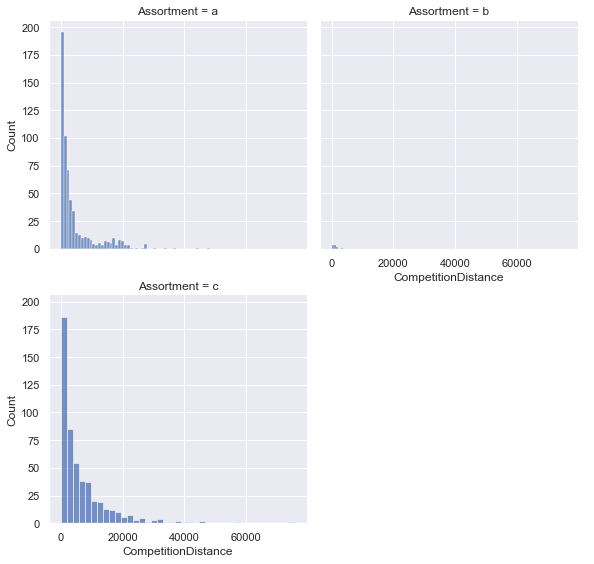

In [67]:
g = sns.FacetGrid(store, col='Assortment', col_wrap=2, height=4, col_order=['a', 'b', 'c'])
g.map(sns.histplot, 'CompetitionDistance', kde=False)
g.set_axis_labels('CompetitionDistance', 'Count')
g.add_legend()

##### Promo2

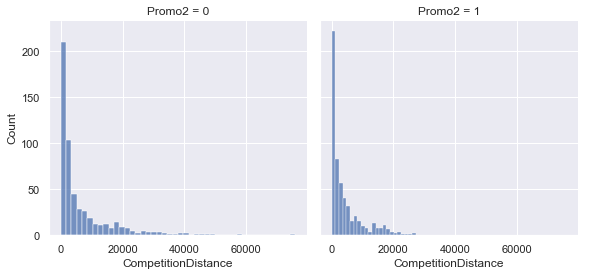

In [68]:
g = sns.FacetGrid(store, col='Promo2', col_wrap=2, height=4)
g.map(sns.histplot, 'CompetitionDistance', kde=False)
g.set_axis_labels('CompetitionDistance', 'Count')
g.add_legend()

##### CompetitionOpenSinceYear

In [20]:
distance = store.groupby('CompetitionOpenSinceYear')['CompetitionDistance'].median().reset_index()

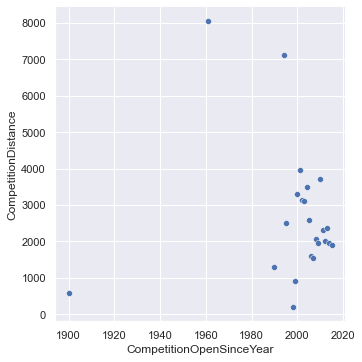

In [24]:
sns.relplot(data=distance, x="CompetitionOpenSinceYear", y="CompetitionDistance")

## Train data check

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


#### Distribution

### missing data

In [99]:
store_cnt = train.groupby('Store')['Date'].count().reset_index()
store_cnt['Date'].value_counts()

942    934
758    180
941      1
Name: Date, dtype: int64

In [45]:
train['Date'] = pd.to_datetime(train['Date'], format='%d/%m/%Y')  # need to define date format
train['yyyymm'] = train['Date'].dt.strftime('%Y%m')
train['yyyy'] = train['Date'].dt.strftime('%Y')

train.sort_values(['Store', 'Date'], inplace=True)

In [48]:
train.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,yyyymm,yyyy
5574,1115,1,2015-07-27,10712,608,1,1,0,1,201507,2015
4459,1115,2,2015-07-28,8093,500,1,1,0,1,201507,2015
3344,1115,3,2015-07-29,7661,473,1,1,0,1,201507,2015
2229,1115,4,2015-07-30,8405,502,1,1,0,1,201507,2015
1114,1115,5,2015-07-31,8680,538,1,1,0,1,201507,2015


In [49]:
train_cnt = train.groupby('Date')['Store'].count().reset_index()

In [50]:
train_cnt.head()

,Date,Store
0,2013-01-01,1114
1,2013-01-02,1115
2,2013-01-03,1115
3,2013-01-04,1115
4,2013-01-05,1115


Text(0, 0.5, 'Count')

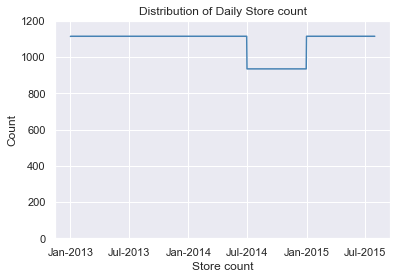

In [55]:
sns.lineplot(data=train_cnt, x='Date', y='Store', color='steelblue')

plt.ylim(0, 1200)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

plt.title('Distribution of Daily Store count')
plt.xlabel('Store count')
plt.ylabel('Count')

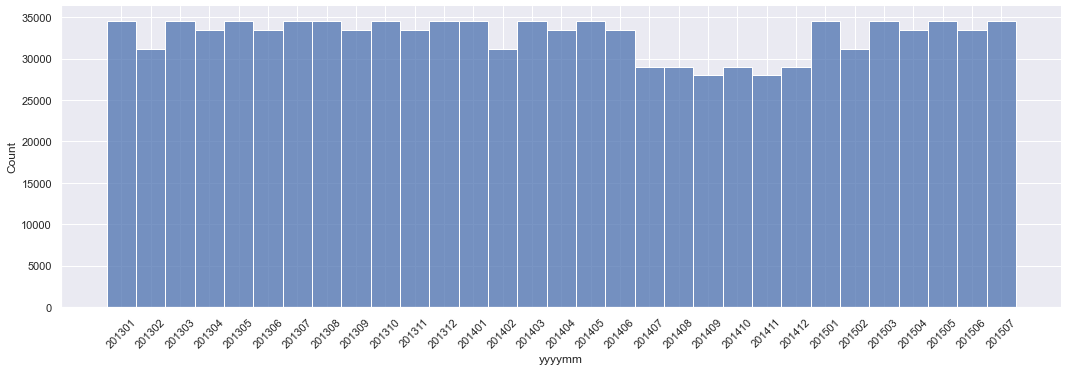

In [98]:
sns.displot(train['yyyymm'], kde=False, binwidth=3, aspect=3, height=5) 
plt.xticks(rotation=45)
plt.show()

In [100]:
train_ym = train.pivot_table(index='Store', columns='yyyymm', aggfunc='size').reset_index()

In [94]:
col_2013 = ['201301', '201302', '201303', '201304', '201305', '201306',
            '201307', '201308', '201309', '201310', '201311', '201312']

col_2014 = ['201401', '201402', '201403', '201404', '201405', '201406',
            '201407', '201408', '201409', '201410', '201411', '201412']

col_2015 = ['201501', '201502', '201503', '201504', '201505', '201506',
            '201507']

In [91]:
train_ym[col_2013].describe()

yyyymm,201301,201302,201303,201304,201305,201306,201307,201308,201309,201310,201311,201312
count,1115.000000,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0
mean,30.999103,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
std,0.029948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,30.000000,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
25%,31.000000,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
50%,31.000000,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
75%,31.000000,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
max,31.000000,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0


In [95]:
train_ym[col_2014].describe()

yyyymm,201401,201402,201403,201404,201405,201406,201407,201408,201409,201410,201411,201412
count,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,935.0,935.0,935.0,935.0,935.0,935.0
mean,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
25%,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
50%,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
75%,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
max,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0


In [96]:
train_ym[col_2015].describe()

yyyymm,201501,201502,201503,201504,201505,201506,201507
count,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0,1115.0
mean,31.0,28.0,31.0,30.0,31.0,30.0,31.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,31.0,28.0,31.0,30.0,31.0,30.0,31.0
25%,31.0,28.0,31.0,30.0,31.0,30.0,31.0
50%,31.0,28.0,31.0,30.0,31.0,30.0,31.0
75%,31.0,28.0,31.0,30.0,31.0,30.0,31.0
max,31.0,28.0,31.0,30.0,31.0,30.0,31.0


In [101]:
train_ym[train_ym['201301']==30]

yyyymm,Store,201301,201302,201303,201304,201305,201306,201307,201308,201309,...,201410,201411,201412,201501,201502,201503,201504,201505,201506,201507
987,988,30.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,...,31.0,30.0,31.0,31.0,28.0,31.0,30.0,31.0,30.0,31.0


In [103]:
train[train['Store']==988].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,yyyymm,yyyy
1015967,988,3,2013-01-02,4992,829,1,0,0,1,201301,2013
1014852,988,4,2013-01-03,4335,737,1,0,0,1,201301,2013
1013737,988,5,2013-01-04,3940,646,1,0,0,1,201301,2013
1012622,988,6,2013-01-05,3849,590,1,0,0,0,201301,2013
1011507,988,7,2013-01-06,0,0,0,0,0,0,201301,2013


In [132]:
train[(train['Store']==13) & (train['StateHoliday'].isin(['a', 'b', 'c']))]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,yyyymm,yyyy
1016107,13,2,2013-01-01,0,0,0,0,a,1,201301,2013
1010532,13,7,2013-01-06,0,0,0,0,a,0,201301,2013
919102,13,5,2013-03-29,0,0,0,1,b,1,201303,2013
915757,13,1,2013-04-01,0,0,0,0,b,1,201304,2013
882307,13,3,2013-05-01,0,0,0,1,a,0,201305,2013
873387,13,4,2013-05-09,0,0,0,0,a,0,201305,2013
861122,13,1,2013-05-20,0,0,0,0,a,0,201305,2013
849972,13,4,2013-05-30,0,0,0,1,a,1,201305,2013
764117,13,4,2013-08-15,0,0,0,1,a,1,201308,2013
709482,13,4,2013-10-03,0,0,0,0,a,0,201310,2013


In [120]:
train['DayOfWeek'].value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

### time window

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [38]:
train['Date'] = pd.to_datetime(train['Date'], format='%d/%m/%Y')
train['yyyymm'] = train['Date'].dt.strftime('%Y%m')
train['yyyy'] = train['Date'].dt.strftime('%Y')

train.sort_values(['Store', 'Date'], inplace=True)

In [7]:
train[train['Sales']==0]['DayOfWeek'].value_counts(dropna=False)

7    141137
4     11219
5      7212
1      7173
3      3743
2      1709
6       678
Name: DayOfWeek, dtype: int64

In [8]:
train[train['Sales']==0]['Open'].value_counts(dropna=False)

0    172817
1        54
Name: Open, dtype: int64

In [5]:
train['sales_yn'] = np.where(train['Sales']>0, 1, 0)

In [13]:
train['sales_yn'].value_counts()

1    844338
0    172871
Name: sales_yn, dtype: int64

- if the store didn't open then sales was 0
- column "Open" is more siginificant than "DayOfWeek"

In [15]:
train.groupby(['Open', 'sales_yn'])['Store'].count()

Open  sales_yn
0     0           172817
1     0               54
      1           844338
Name: Store, dtype: int64

In [16]:
train.groupby(['DayOfWeek', 'sales_yn'])['Store'].count()

DayOfWeek  sales_yn
1          0             7173
           1           137557
2          0             1709
           1           143955
3          0             3743
           1           141922
4          0            11219
           1           134626
5          0             7212
           1           138633
6          0              678
           1           144052
7          0           141137
           1             3593
Name: Store, dtype: int64

In [9]:
train.groupby('Open')['DayOfWeek'].value_counts()

Open  DayOfWeek
0     7            141137
      4             11201
      5              7205
      1              7170
      3              3729
      2              1703
      6               672
1     6            144058
      2            143961
      3            141936
      5            138640
      1            137560
      4            134644
      7              3593
Name: DayOfWeek, dtype: int64

#### excluding the date closed

In [6]:
train_open = train[train['Open']==1]

In [36]:
train.sort_values(by=['Store', 'Date'], inplace=True)

In [7]:
train_open.sort_values(by=['Store', 'Date'], inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### ACF / PACF

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 1016095 to 1114
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
 9   yyyymm         1017209 non-null  object        
 10  yyyy           1017209 non-null  object        
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 93.1+ MB


In [40]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,yyyymm,yyyy
1016095,1,2,2013-01-01,0,0,0,0,a,1,201301,2013
1014980,1,3,2013-01-02,5530,668,1,0,0,1,201301,2013
1013865,1,4,2013-01-03,4327,578,1,0,0,1,201301,2013
1012750,1,5,2013-01-04,4486,619,1,0,0,1,201301,2013
1011635,1,6,2013-01-05,4997,635,1,0,0,1,201301,2013


/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

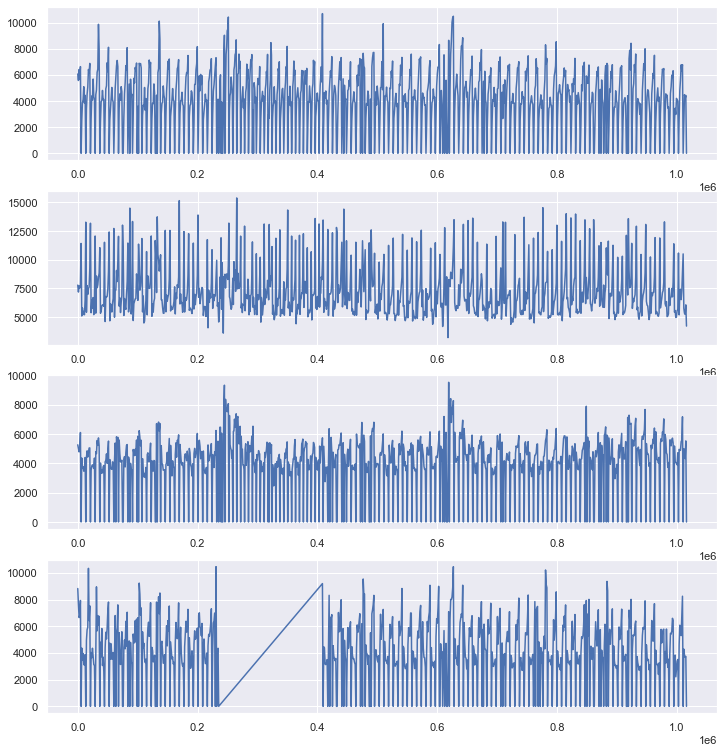

In [37]:
# Select sales data for each store
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales']
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

# Create subplots
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 13))


# Plot the sales data, resampled weekly
sales_a.plot(ax=ax1)
sales_b.plot(ax=ax2)
sales_c.plot(ax=ax3)
sales_d.plot(ax=ax4)


/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

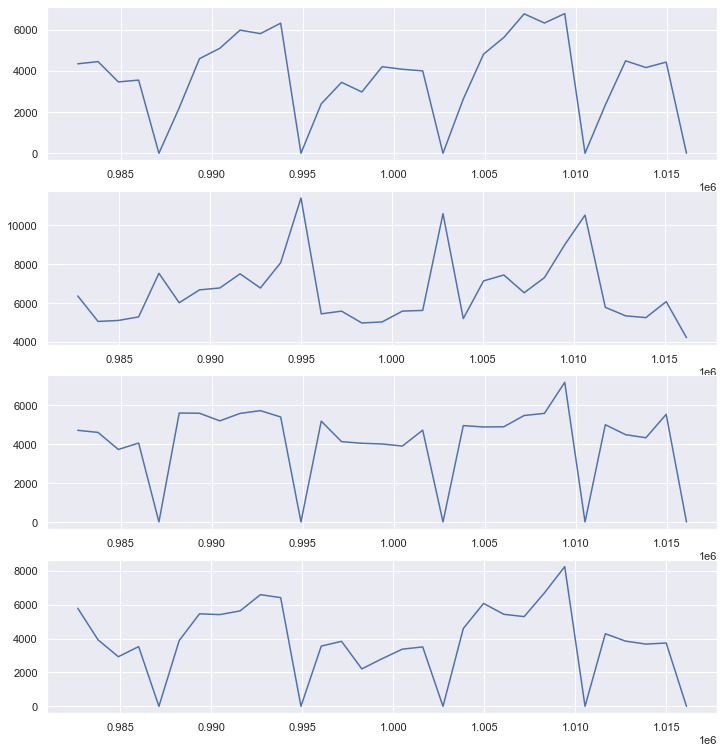

In [41]:
# Select sales data for each store
sales_a = train[(train.Store == 2) & (train['yyyymm']=='201301')]['Sales']
sales_b = train[(train.Store == 85) & (train['yyyymm']=='201301')]['Sales']
sales_c = train[(train.Store == 1) & (train['yyyymm']=='201301')]['Sales']
sales_d = train[(train.Store == 13) & (train['yyyymm']=='201301')]['Sales']

# Create subplots
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 13))


# Plot the sales data, resampled weekly
sales_a.plot(ax=ax1)
sales_b.plot(ax=ax2)
sales_c.plot(ax=ax3)
sales_d.plot(ax=ax4)

##### sampling data with all dates

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


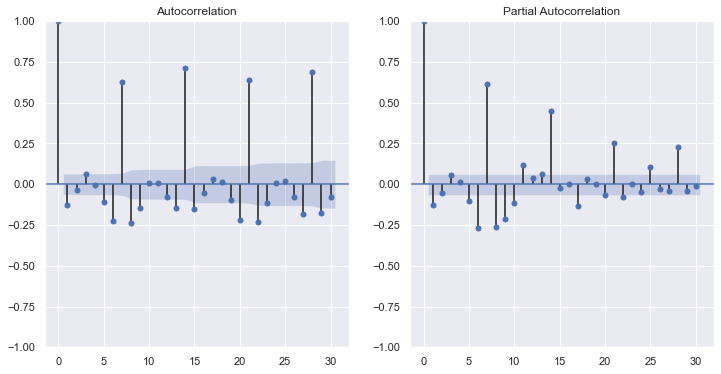

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


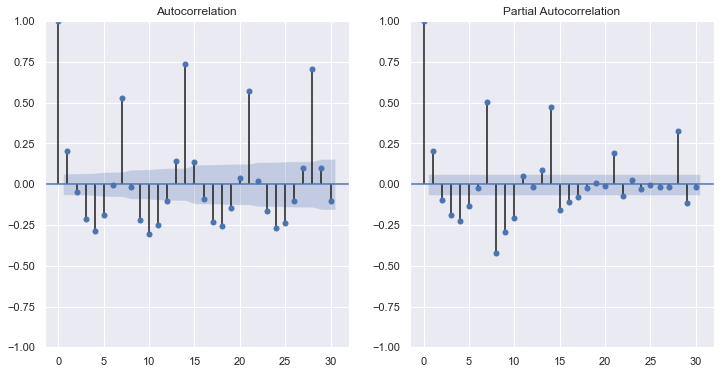

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


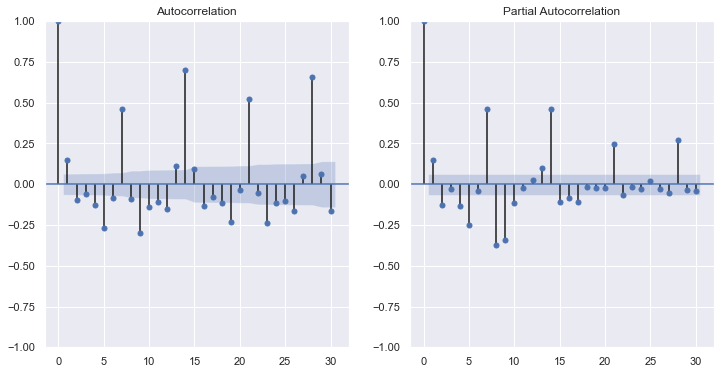

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


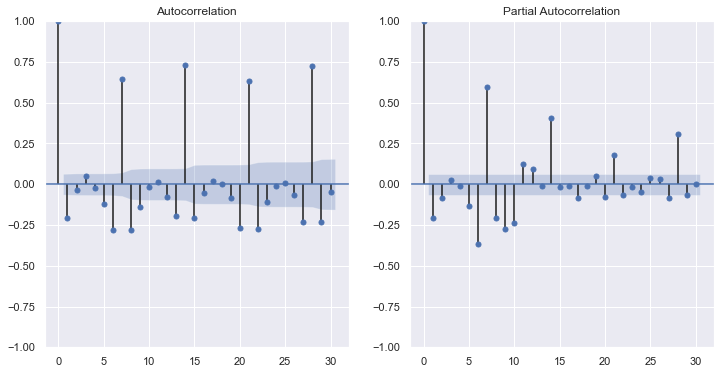

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


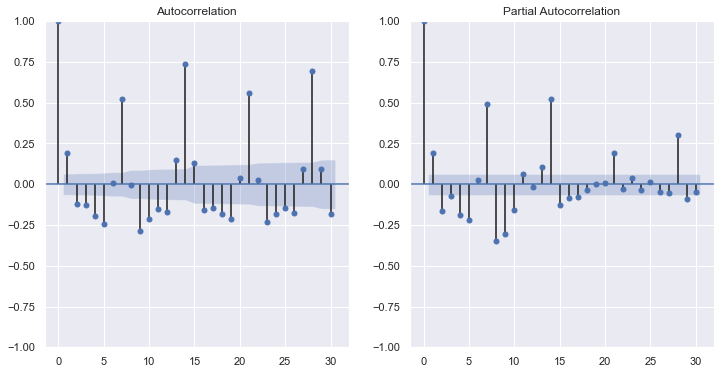

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


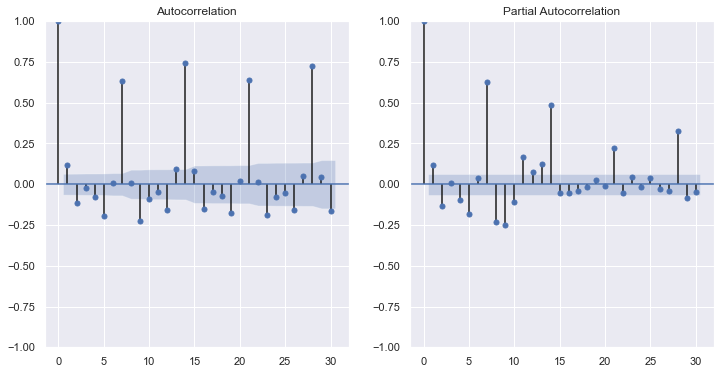

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


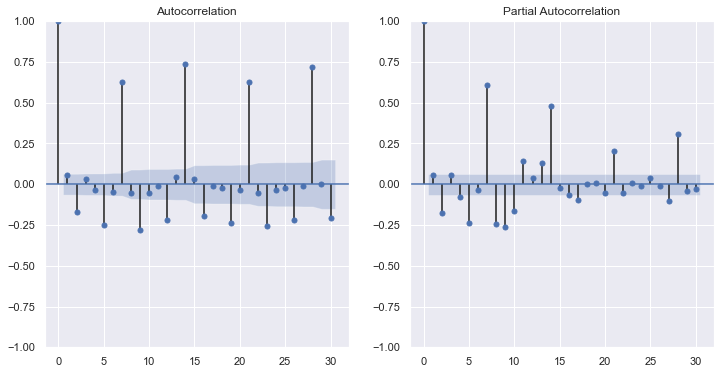

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


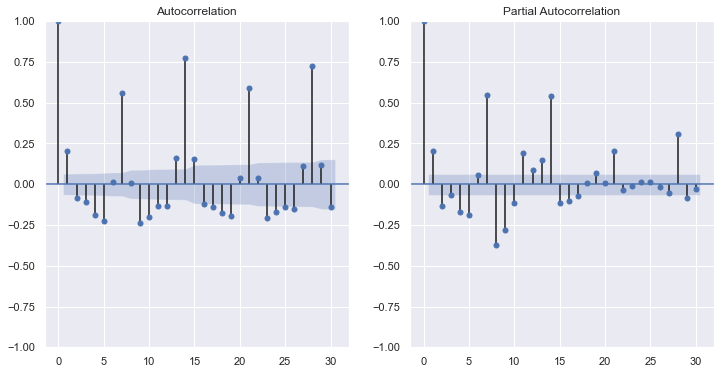

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


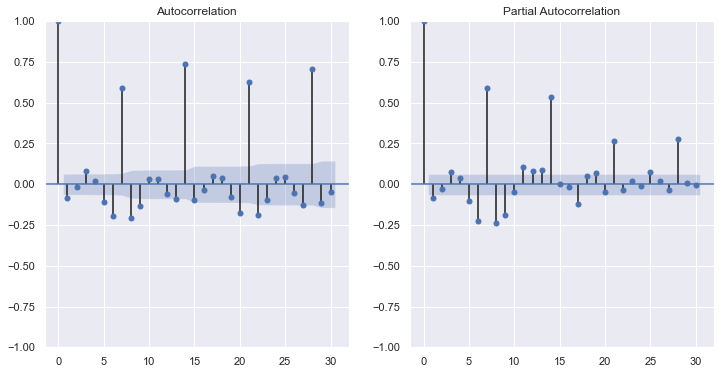

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


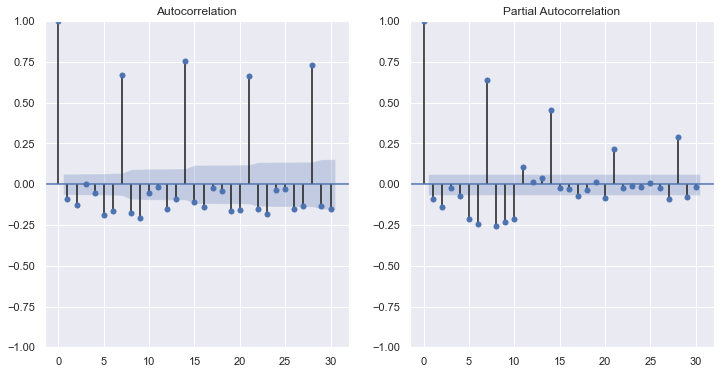

In [19]:
for i in range(1, 11):
    sales_store = train[train['Store']==i]

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(sales_store['Sales'], ax=plt.gca(), lags=30)
    plt.subplot(122)
    plot_pacf(sales_store['Sales'], ax=plt.gca(), lags=30)  # Adjust the lags as needed
    plt.show()

##### sampling data with all dates: store 2, 85, 1, 13

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


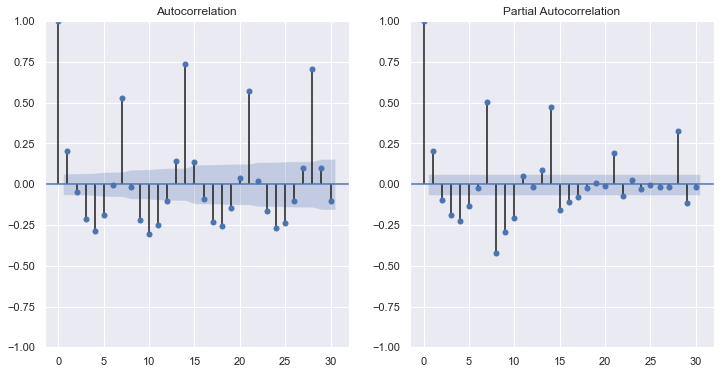

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


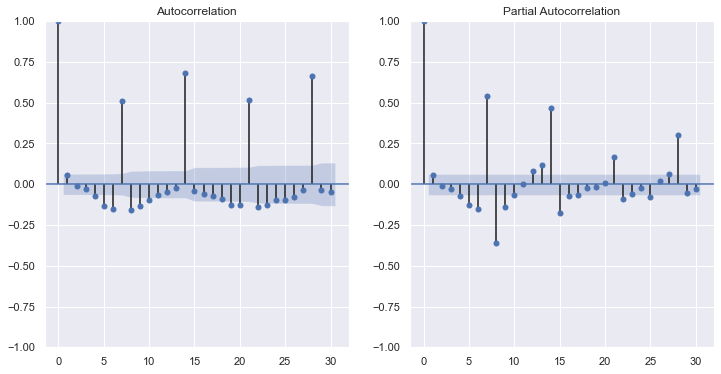

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


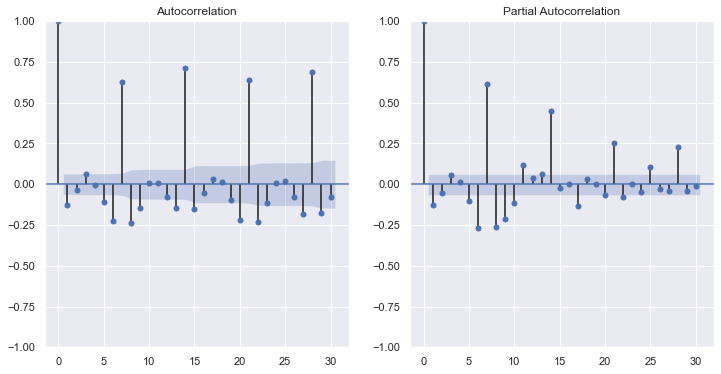

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


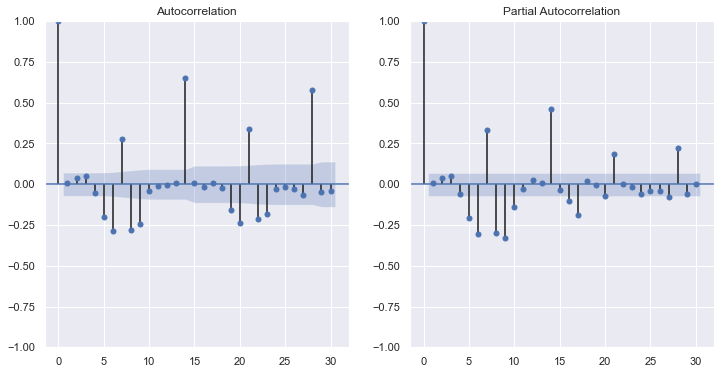

In [22]:
# sampling from different store types

for i in [2, 85, 1, 13]:
    sales_store = train[train['Store']==i]

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(sales_store['Sales'], ax=plt.gca(), lags=30)
    plt.subplot(122)
    plot_pacf(sales_store['Sales'], ax=plt.gca(), lags=30)  # Adjust the lags as needed
    plt.show()

##### sampling data removing closed dates

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


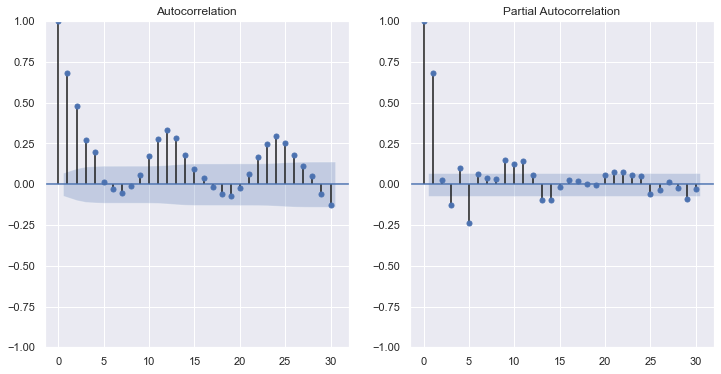

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


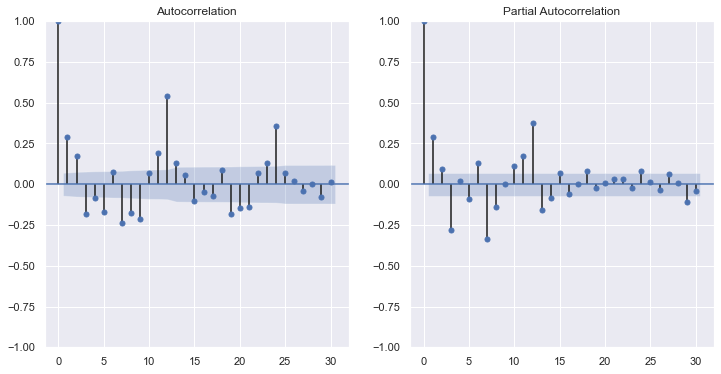

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


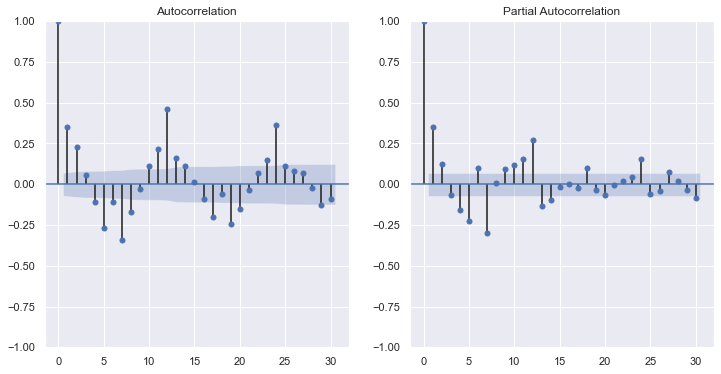

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


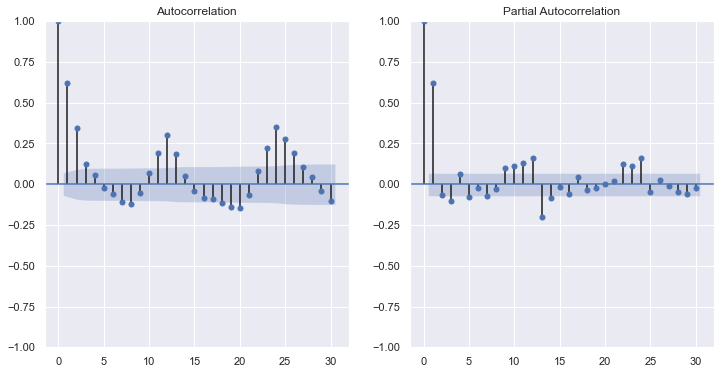

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


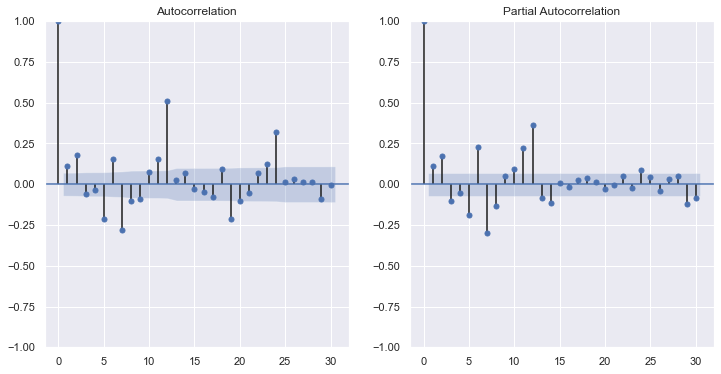

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


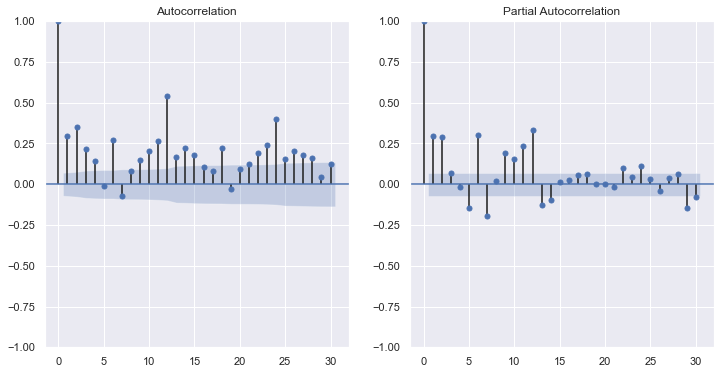

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


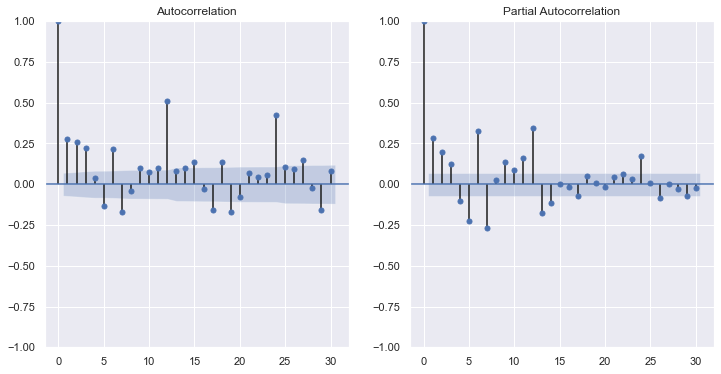

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


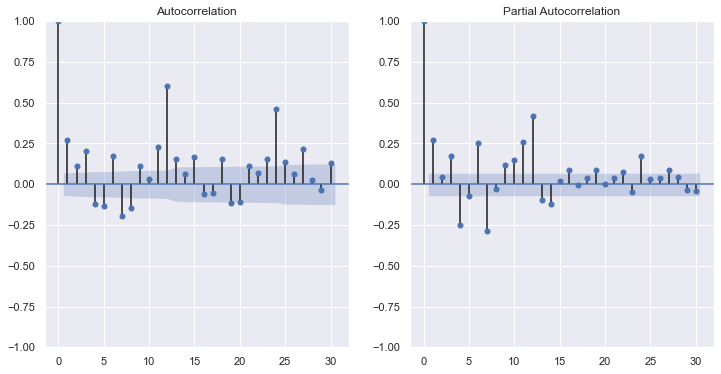

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


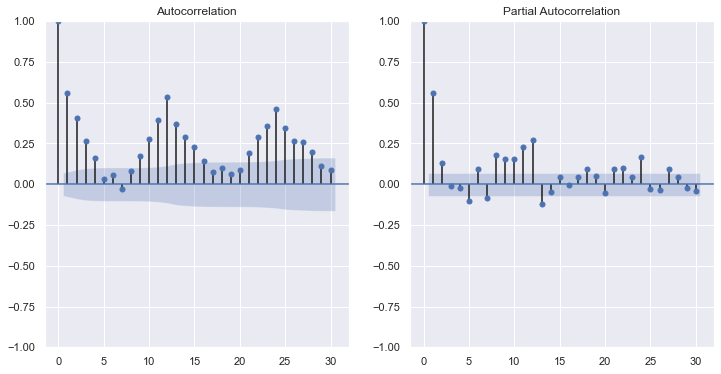

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


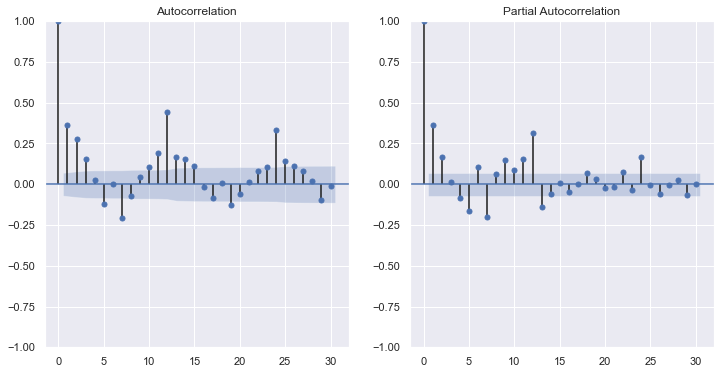

In [17]:
for i in range(1, 11):
    sales_store = train_open[train_open['Store']==i]

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(sales_store['Sales'], ax=plt.gca(), lags=30)
    plt.subplot(122)
    plot_pacf(sales_store['Sales'], ax=plt.gca(), lags=30)  # Adjust the lags as needed
    plt.show()

##### sampling data removing closed dates: store 2, 85, 1, 13

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


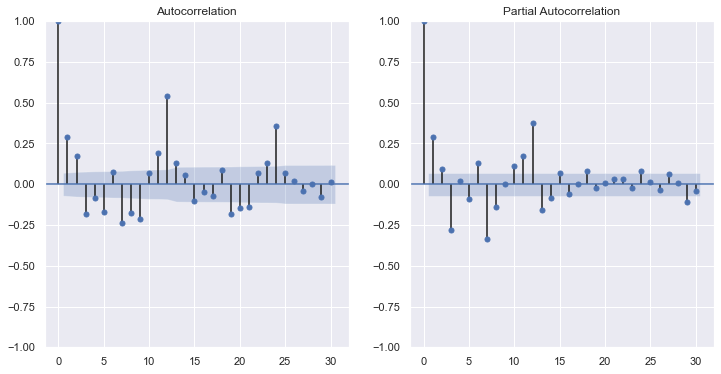

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


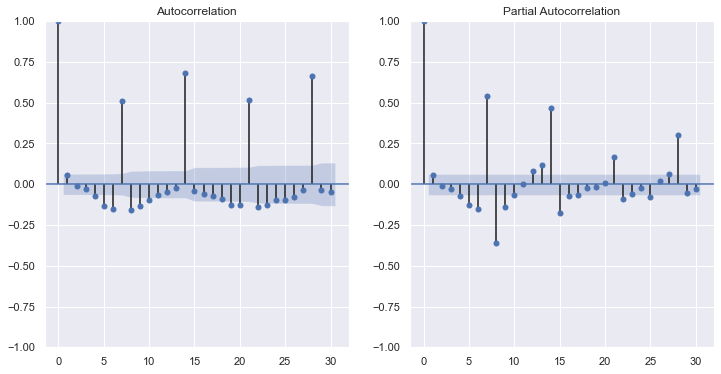

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


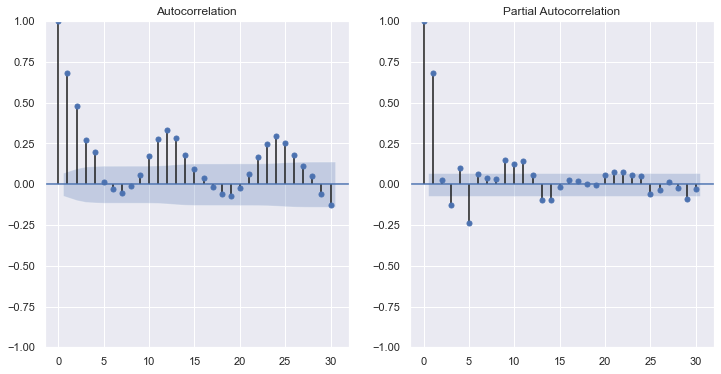

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


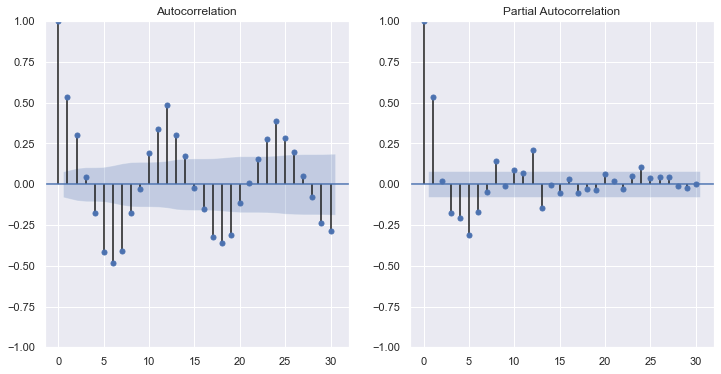

In [20]:
for i in [2, 85, 1, 13]:
    sales_store = train_open[train_open['Store']==i]

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(sales_store['Sales'], ax=plt.gca(), lags=30)
    plt.subplot(122)
    plot_pacf(sales_store['Sales'], ax=plt.gca(), lags=30)  # Adjust the lags as needed
    plt.show()

#### time shift columns

In [29]:
train_open['t1'] = train_open.groupby('Store')['Sales'].shift(1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
train_open[train_open['Store']==3].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,sales_yn,t1
1014982,3,3,2013-01-02,6823,805,1,0,0,1,1,NaN
1013867,3,4,2013-01-03,5902,721,1,0,0,1,1,6823.0
1012752,3,5,2013-01-04,6069,690,1,0,0,1,1,5902.0
1011637,3,6,2013-01-05,4523,525,1,0,0,0,1,6069.0
1009407,3,1,2013-01-07,12247,1079,1,1,0,0,1,4523.0


## Test data check

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Store          41088 non-null  int64  
 1   DayOfWeek      41088 non-null  int64  
 2   Date           41088 non-null  object 
 3   Sales          0 non-null      float64
 4   Customers      0 non-null      float64
 5   Open           41077 non-null  float64
 6   Promo          41088 non-null  int64  
 7   StateHoliday   41088 non-null  object 
 8   SchoolHoliday  41088 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 2.8+ MB


### missing data

#### Date

In [113]:
store_cnt = test.groupby('Store')['Date'].count().reset_index()
store_cnt['Date'].value_counts()

48    856
Name: Date, dtype: int64

In [114]:
test['Date'] = pd.to_datetime(test['Date'], format='%d/%m/%Y')
test['yyyymm'] = test['Date'].dt.strftime('%Y%m')
test['yyyy'] = test['Date'].dt.strftime('%Y')

In [115]:
test.sort_values(['Store', 'Date'], inplace=True)

In [119]:
test['DayOfWeek'].value_counts()

7    5992
6    5992
4    5992
3    5992
2    5992
1    5992
5    5136
Name: DayOfWeek, dtype: int64

#### Open

In [122]:
test['Open'].value_counts(dropna=False)

1.0    35093
0.0     5984
NaN       11
Name: Open, dtype: int64

In [125]:
test[test['Store']==622]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,yyyymm,yyyy
40711,622,6,2015-08-01,NaN,NaN,1.0,0,0,0,201508,2015
39855,622,7,2015-08-02,NaN,NaN,0.0,0,0,0,201508,2015
38999,622,1,2015-08-03,NaN,NaN,1.0,1,0,1,201508,2015
38143,622,2,2015-08-04,NaN,NaN,1.0,1,0,1,201508,2015
37287,622,3,2015-08-05,NaN,NaN,1.0,1,0,1,201508,2015
36431,622,4,2015-08-06,NaN,NaN,1.0,1,0,1,201508,2015
35575,622,5,2015-08-07,NaN,NaN,1.0,1,0,1,201508,2015
34719,622,6,2015-08-08,NaN,NaN,1.0,0,0,0,201508,2015
33863,622,7,2015-08-09,NaN,NaN,0.0,0,0,0,201508,2015
33007,622,1,2015-08-10,NaN,NaN,1.0,0,0,1,201508,2015


In [124]:
test[test['Open'].isna()].sort_values('Date')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,yyyymm,yyyy
10751,622,6,2015-09-05,NaN,NaN,NaN,0,0,0,201509,2015
9039,622,1,2015-09-07,NaN,NaN,NaN,0,0,0,201509,2015
8183,622,2,2015-09-08,NaN,NaN,NaN,0,0,0,201509,2015
7327,622,3,2015-09-09,NaN,NaN,NaN,0,0,0,201509,2015
6471,622,4,2015-09-10,NaN,NaN,NaN,0,0,0,201509,2015
5615,622,5,2015-09-11,NaN,NaN,NaN,0,0,0,201509,2015
4759,622,6,2015-09-12,NaN,NaN,NaN,0,0,0,201509,2015
3047,622,1,2015-09-14,NaN,NaN,NaN,1,0,0,201509,2015
2191,622,2,2015-09-15,NaN,NaN,NaN,1,0,0,201509,2015
1335,622,3,2015-09-16,NaN,NaN,NaN,1,0,0,201509,2015


### create time shift variable for test data

#### 1. add the previous 7d sales data into test

In [8]:
train['Date'] = pd.to_datetime(train['Date'], format='%d/%m/%Y')
test['Date'] = pd.to_datetime(test['Date'], format='%d/%m/%Y')

In [32]:
store_lst = test['Store'].unique()
train_7d = train[(train['Date']>'2015-07-24') & (train['Store'].isin(store_lst))]
test_all = pd.concat([train_7d, test], axis=0)

In [36]:
test_all.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1
2,3,5,2015-07-31,8314.0,821.0,1.0,1,0,1
6,7,5,2015-07-31,15344.0,1414.0,1.0,1,0,1
7,8,5,2015-07-31,8492.0,833.0,1.0,1,0,1
8,9,5,2015-07-31,8565.0,687.0,1.0,1,0,1


In [37]:
test_all.shape

(47080, 9)

#### 2. sort by store, date

In [38]:
test_all.sort_values(['Store', 'Date'], inplace=True)

#### 3. create shift for 7 days

In [65]:
n = 7

for i in range(1, n+1):
    test_all[f't{i}'] = test_all.groupby('Store')['Sales'].shift(i)

In [66]:
test_all.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,t1,t2,t3,t4,t5,t6,t7
6690,1,6,2015-07-25,4364.0,500.0,1.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5575,1,7,2015-07-26,0.0,0.0,0.0,0,0,0,4364.0,NaN,NaN,NaN,NaN,NaN,NaN
4460,1,1,2015-07-27,6102.0,612.0,1.0,1,0,1,0.0,4364.0,NaN,NaN,NaN,NaN,NaN
3345,1,2,2015-07-28,5011.0,560.0,1.0,1,0,1,6102.0,0.0,4364.0,NaN,NaN,NaN,NaN
2230,1,3,2015-07-29,4782.0,523.0,1.0,1,0,1,5011.0,6102.0,0.0,4364.0,NaN,NaN,NaN
1115,1,4,2015-07-30,5020.0,546.0,1.0,1,0,1,4782.0,5011.0,6102.0,0.0,4364.0,NaN,NaN
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,5020.0,4782.0,5011.0,6102.0,0.0,4364.0,NaN
40232,1,6,2015-08-01,1.0,NaN,1.0,0,0,1,5263.0,5020.0,4782.0,5011.0,6102.0,0.0,4364.0
39376,1,7,2015-08-02,NaN,NaN,0.0,0,0,1,1.0,5263.0,5020.0,4782.0,5011.0,6102.0,0.0
38520,1,1,2015-08-03,NaN,NaN,1.0,1,0,1,NaN,1.0,5263.0,5020.0,4782.0,5011.0,6102.0


## Create Promo2 variable

In [107]:
promo2 = store[store['Promo2']==1][['Store', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']]

#### create promo2 since yyyymm

In [108]:
promo2['Promo2SinceYear'] = promo2['Promo2SinceYear'].astype(int).astype(str)
promo2['Promo2SinceWeek'] = promo2['Promo2SinceWeek'].astype(int).astype(str)

promo2['promo2_dt'] = pd.to_datetime(promo2['Promo2SinceYear'] + promo2['Promo2SinceWeek'] + '1', format='%Y%W%w')

promo2['promo2_yyyymm'] = promo2['promo2_dt'].dt.strftime('%Y%m')
promo2['promo2_mm'] = promo2['promo2_dt'].dt.strftime('%m')

#### convert interval column

In [109]:
promo2['PromoInterval'].value_counts(dropna=False)

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [110]:
promo2.loc[promo2['PromoInterval'] == 'Jan,Apr,Jul,Oct', 'PromoInterval'] = 1
promo2.loc[promo2['PromoInterval'] == 'Feb,May,Aug,Nov', 'PromoInterval'] = 2
promo2.loc[promo2['PromoInterval'] == 'Mar,Jun,Sept,Dec', 'PromoInterval'] = 3

#### merge with train data

In [111]:
df = pd.merge(train, promo2, how='left', on='Store')

In [113]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['tran_yyyymm'] = df['Date'].dt.strftime('%Y%m')
df['tran_yyyy'] = df['Date'].dt.strftime('%Y')
df['tran_mm'] = df['Date'].dt.strftime('%m')

#### promo2_yn

In [114]:
df['Promo2_yn'] = np.where(df['tran_yyyymm'] >= df['promo2_yyyymm'], 1, 0)

In [115]:
df['Promo2_yn'].value_counts()

0    577834
1    439375
Name: Promo2_yn, dtype: int64

#### promo2_start

In [120]:
df['promo2_start'] = 0

# promo2 since week
df.loc[df['tran_yyyymm'] == df['promo2_yyyymm'], 'promo2_start'] = 1

# transaction in the promo2 since month
interval_1 = ['01', '04', '07', '10']
interval_2 = ['02', '05', '08', '11']
interval_3 = ['03', '06', '09', '12']

df.loc[(df['tran_yyyymm'] >= df['promo2_yyyymm']) & 
       (df['PromoInterval'] == 1) &
       (df['tran_mm'].isin(interval_1)), 'promo2_start'] = 1

df.loc[(df['tran_yyyymm'] >= df['promo2_yyyymm']) & 
       (df['PromoInterval'] == 2) &
       (df['tran_mm'].isin(interval_2)), 'promo2_start'] = 1

df.loc[(df['tran_yyyymm'] >= df['promo2_yyyymm']) & 
       (df['PromoInterval'] == 3) &
       (df['tran_mm'].isin(interval_3)), 'promo2_start'] = 1

In [123]:
df['promo2_start'].value_counts()

0    863505
1    153704
Name: promo2_start, dtype: int64